In [2]:
from datetime import datetime
import sys; sys.path.append('..')

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from lib.data.santa_fe import load_santa_fe
from lib.utils.time_series import create_time_series_inputs_targets

# 3. Time-Series Prediction with a Long Short-Term Memory Network

Long Short Term Memory networks, usually just called "LSTMs", are a special kind of RNN, capable of learning long-term dependencies ([Hochreiter and Schmidhuber, 1997](https://www.nichenjie.com/mdres/posts/2018/lstm/2604.pdf)). Wheras the MLP-based recurrent model we discussed in the previous notebook takes in an entire (fixed-size) time series as input, an LSTM takes in the time series data points *one at a time*. For each data point, the LSTM cell produces two outputs: a hidden state $h_t$ and a cell state $c_t$. The hidden state and the cell state correspond to short-term and long-term memory, respectively. Apart from the time-series data point $x_t$, an LSTM cell takes two other inputs: the previous hidden state $h_{t-1}$ and the previous cell state $c_{t-1}$.

The hidden state $h_t$ produced by the LSTM can be interpreted as a vector-representation of the predicted data point at the next time instant. In our implementation below, we will project $h_t$ onto a single scalar, which will then be the predicted data point itself.

As you can see in the figure below, the LSTM cell modifies the previous cell state and hidden state. This happens via a *gating* mechanism. Based on the previous hidden state $h_{t-1}$ and the current data point $x_t$, the LSTM cell computes three *gating vectors* (the outputs of each $\sigma$ operation) that contain elements between 0 and 1. When element-wise multiplying such a gating vector with another vector, each element of the gating vector acts as a little *gate* that allows data of the other vector to (partially) pass through or not. A zero blocks the data, a one lets the data through.

For example, the *cell gate* is the gate produced by the $\sigma$ operation at the left-hand side of the figure. It chooses which elements of the previous cell state $c_{t-1}$ will be kept and which will be removed. The *input gate* (second from the left) chooses which information will be added to the new cell state, while the *output gate* (right-hand side $\sigma$) chooses which information of the new cell state $c_t$ (after applying $\tanh$) to use for $h_t$.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/93/LSTM_Cell.svg" style="max-width: 500px;"/>

Note that **the same cell is used at each time instant**, but always with **new inputs** $h_{t-1}$, $c_{t-1}$ and $x_t$.

The output of every gate is produced by passing $x_t$ and $h_{t-1}$ each through their own fully-connected layer, adding the results and applying a sigmoid operation. For producing the result of the $\tanh$ branch in the middle of the figure, $x_t$ and $h_{t-1}$ are also each passed through their own fully-connected layer. The results are again added together but passed through a $\tanh$ operation instead of a sigmoid.

As such, the LSTM cell contains **8 fully-connected layers** with learnable parameters. These parameters can be trained via a gradient descent-based optimization method.

## 3.1 LSTM-based Model for Time-Series Prediction

We have implemented an LSTM-based regression model below. The model employs [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) to process a sequence of inputs. As you can see in the `forward()` method, the resulting hidden state vector is passed through a fully-connected layer, which transforms it into a prediction for the next time instant.

In [3]:
class LSTMRegressor(nn.Module):
    def __init__(self, hidden_size, input_size=1, num_layers=1):
        """
        Args:
            hidden_size (int): The number of features to use for the hidden state.
            input_size (int): The number of dimensions a measurement has at a single time step.
            num_layers (int): Number of recurrent layers. E.g., setting `num_layers=2` would
                mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM
                taking in the hidden states of the first LSTM and computing the final results.
        """
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize the LSTM
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
        )

        # Initialize the fully-connected layer
        self.linear = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.input_size
        )

    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor of shape `(N, L, H_in)`, `(N, L)` or `(L,)` with `N`
                the batch size, `L` the sequence length and `H_in` the input size. If
                the dimensions of `L` and/or `H_in` are not given, they are assumend to
                be 1.
        """
        orig_ndim = x.ndim

        if orig_ndim == 1:
            # Assume batch size and input size are 1
            x = x[None, ..., None]
        if orig_ndim == 2:
            # Assume input size is 1
            x = x[..., None]

        N, L, H_in = x.shape

        assert self.input_size == H_in

        # Reshape to (L, N, H_in) for LSTM input
        x = x.permute(1, 0, 2)

        # `output` contains hidden state from last layer for each sequence element
        # `h_n` contains the hidden state from all layers for the last sequence element
        # `c_n` contains the cell state from all layers for the last sequence element
        output, (h_n, c_n) = self.lstm(x)

        # Select the last hidden state from the last element...
        h_last = h_n[-1]  # (Note: same as output[-1])

        # ...and pass it through a fully-connected layer
        out = self.linear(h_last)

        if orig_ndim == 1:
            # Remove batch dimension
            out = out[0, :]

        return out

The number of features in the hidden state can be controlled with the `hidden_size` argument of the constructor. For example, one can create an LSTM-based model with a hidden state vector of length 128 as follows:

```python
# Create the LSTM model
lstm = LSTMRegressor(hidden_size=128)
```

Once you have created the model, you can use it in a similar way as the MLP from the [previous notebook](./2_nn_time_series.ipynb):

```python
# Predict the next time series value
y_next = lstm(time_series)
```

Where `time_series` is a tensor of shape $(N, L)$ with $N$ the batch size and $L$ the length of a single time series sequence. Then, `y_next` will be a tensor of shape $(N, 1)$ containing the next predicted value for each sequence. Just like with the MLP, we can compare these predictions with the ground-truth values and compute (and backpropagate) the loss.

## 3.2 Making Time-Series Predictions

In the previous notebook, you have implemented the function `run_recurrent_model()` to produce time-series predictions for an MLP-based recurrent model. One limitation of such a model is that the sequence length is *fixed*, i.e., it is equal to the number of input neurons of the MLP. This is an important difference with an LSTM-based model. An LSTM takes in a data point at a single time instant, the previous hidden state and the previous cell state and produces the next hidden state and the next cell state. There is no restriction on the length of the time-series sequence.

Paste your `run_recurrent_model()` implementation of the previous notebook below and modify it so that the length of the time-series grows as the model predicts more data points (instead of dropping the oldest data point).

In [4]:
# Predict multiple consequtive outputs
@torch.no_grad()
def run_recurrent_model(model, x_0, num_iters):
    """
    Create a time series by recurrenctly feeding the output back into the input.
    """
    # Create a tensor to store the outputs in
    outputs = torch.zeros(num_iters)

    x_t = x_0
    for t in range(num_iters):
        # Compute the next value
        y_t = model(x_t)

        # Store the output
        outputs[t] = y_t

        # Create the input for the next time by addin this new output to the previous input
        x_t = torch.cat([x_t, y_t]) 

    return outputs

## 3.3 Exercise

Reuse your training code from the [previous notebook](./2_nn_time_series.ipynb) to model the Santa Fe dataset with the `LSTMRegressor` class.

- Train the LSTM-based model and explain the design process. Discuss how the model looks, the parameters that you tune,... What is the effect of changing the lag value for the LSTM network?
- Afterwards, try to predict the validation set. Use your newly implemented `run_recurrent_model()` function for this.
- Compare results of the recurrent neural network of the previous notebook with the LSTM. Which model do you prefer and why?

### Different lag

In [5]:
# Get the dataset
train_set, val_set = load_santa_fe()

#Standardize values
norm_train_set = torch.div((train_set - train_set.mean()), train_set.std())
norm_val_set = torch.div((val_set - val_set.mean()), val_set.std())

# Create the train features and targets with different lags
train_inputs_lag_200, train_targets_lag_200 = create_time_series_inputs_targets(norm_train_set, 200)
train_inputs_lag_500, train_targets_lag_500 = create_time_series_inputs_targets(norm_train_set, 500)

In [6]:
# Create the lstms that will be trained on different lags
lstm_lag_200 = LSTMRegressor(hidden_size=8)
lstm_lag_500 = LSTMRegressor(hidden_size=8)

In [7]:
# Training step
def training_step(model, x_train, y_train, loss_fn, optimizer, writer, epoch):
    # Pass the training data through the model
    y_pred = model(x_train)

    # Compute the loss value
    loss = loss_fn(y_pred, y_train)

    # Clean up gradients from previous iteration
    optimizer.zero_grad()

    # Compute grad of loss wrt model params
    loss.backward()

    # Take optimization step
    optimizer.step()

    # Log the training loss
    writer.add_scalar(f"{loss_fn.__class__.__name__}/Train", loss, epoch)

In [8]:
# Create the optimizers
optimizer_lag_200 = optim.Adam(
    params=lstm_lag_200.parameters(),
    lr=0.001
)
optimizer_lag_500 = optim.Adam(
    params=lstm_lag_500.parameters(),
    lr=0.001
)

# Create a loss function
loss_fn = nn.MSELoss()

# Create the SummaryWriter instance
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name_lag_200 = f'lstm_time_series_lag_200_{timestamp}'
run_name_lag_500 = f'lstm_time_series_lag_500_{timestamp}'
writer_lag_200 = SummaryWriter(log_dir=f'run_lstm_time_series/{run_name_lag_200}')
writer_lag_500 = SummaryWriter(log_dir=f'run_lstm_time_series/{run_name_lag_500}')


NUM_EPOCHS = 1000

# Train the different models
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(lstm_lag_200, train_inputs_lag_200, train_targets_lag_200, loss_fn, optimizer_lag_200, writer_lag_200, epoch)
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(lstm_lag_500, train_inputs_lag_500, train_targets_lag_500, loss_fn, optimizer_lag_500, writer_lag_500, epoch)

2022-12-28 17:31:57.909570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-28 17:31:58.067736: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-28 17:31:58.070664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-28 17:31:58.070702: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [9]:
# Get the different inputs for validation
input_samples_200 = norm_train_set[-200:]
input_samples_500 = norm_train_set[-500:]

# Predict the 100 samples of the validation set
pred_samples_lag_200 = run_recurrent_model(lstm_lag_200, input_samples_200, 100)
pred_samples_lag_500 = run_recurrent_model(lstm_lag_500, input_samples_500, 100)


# Calculate the error
loss_fn = nn.MSELoss()
loss_lag_200 = loss_fn(pred_samples_lag_200, norm_val_set)
loss_lag_500 = loss_fn(pred_samples_lag_500, norm_val_set)

print(f'val loss lag 200: {loss_lag_200}, val loss lag 500: {loss_lag_500}')

val loss lag 200: 1.46721613407135, val loss lag 500: 0.8283810615539551


In [10]:
def visualize_prediction_performance(pred_samples, target_samples):
    # Create Matplotlib figure and axes
    fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

    axes[0].set_title("Predicted samples")
    axes[0].plot(pred_samples)

    axes[1].set_title("Target samples")
    axes[1].plot(target_samples)

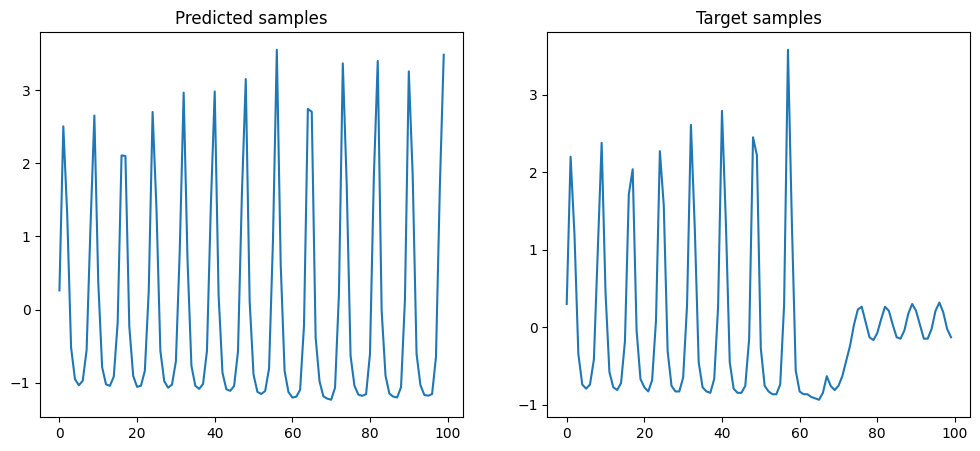

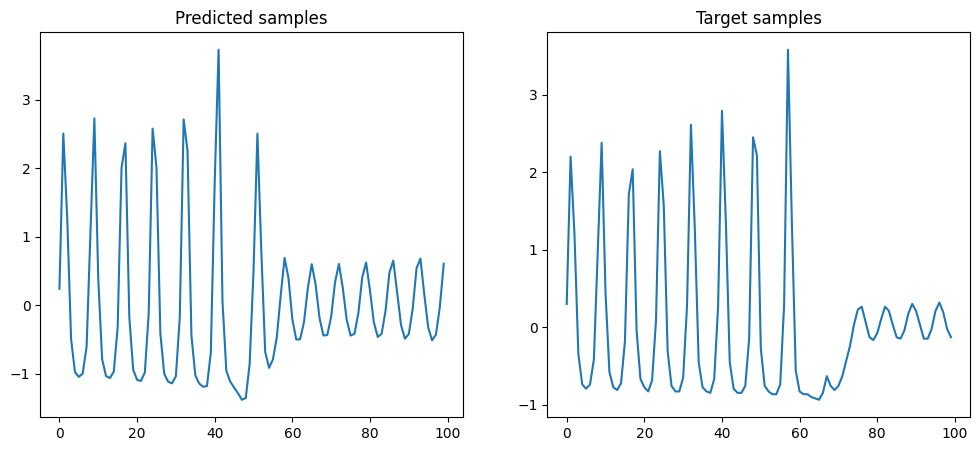

In [11]:
visualize_prediction_performance(pred_samples_lag_200, norm_val_set)
visualize_prediction_performance(pred_samples_lag_500, norm_val_set)

### Different hidden size

In [20]:
# Get the dataset
train_set, val_set = load_santa_fe()

#Standardize values
norm_train_set = torch.div((train_set - train_set.mean()), train_set.std())
norm_val_set = torch.div((val_set - val_set.mean()), val_set.std())

# Create the train features and targets
train_inputs_lag_500, train_targets_lag_500 = create_time_series_inputs_targets(norm_train_set, 500)

In [21]:
# Create the lstms with different hidden sizes
lstm_hidden_8= LSTMRegressor(hidden_size=8)
lstm_hidden_32= LSTMRegressor(hidden_size=32)

In [22]:
# Create the optimizers
optimizer_hidden_8 = optim.Adam(
    params=lstm_hidden_8.parameters(),
    lr=0.001
)
optimizer_hidden_32 = optim.Adam(
    params=lstm_hidden_32.parameters(),
    lr=0.001
)

# Create a loss function
loss_fn = nn.MSELoss()

# Create the SummaryWriter instance
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name_hidden_8 = f'lstm_time_series_hidden_8_{timestamp}'
run_name_hidden_32 = f'lstm_time_series_hidden_32_{timestamp}'

writer_hidden_8 = SummaryWriter(log_dir=f'run_lstm_time_series/{run_name_hidden_8}')
writer_hidden_32 = SummaryWriter(log_dir=f'run_lstm_time_series/{run_name_hidden_32}')

NUM_EPOCHS = 1000

# Train the different models
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(lstm_hidden_8, train_inputs_lag_500, train_targets_lag_500, loss_fn, optimizer_hidden_8, writer_hidden_8, epoch)
for epoch in tqdm(range(NUM_EPOCHS)):
    # Run training
    training_step(lstm_hidden_32, train_inputs_lag_500, train_targets_lag_500, loss_fn, optimizer_hidden_32, writer_hidden_32, epoch)

  1%|          | 9/1000 [00:14<25:56,  1.57s/it]


KeyboardInterrupt: 

In [15]:
# Get the different inputs for validation
input_samples_500 = norm_train_set[-500:]

# Predict the 100 samples of the validation set
pred_samples_hidden_8 = run_recurrent_model(lstm_hidden_8, input_samples_500, 100)
pred_samples_hidden_32 = run_recurrent_model(lstm_hidden_32, input_samples_500, 100)

# Calculate the error
loss_fn = nn.MSELoss()
loss_hidden_8 = loss_fn(pred_samples_hidden_8, norm_val_set)
loss_hidden_32 = loss_fn(pred_samples_hidden_32, norm_val_set)

print(f'val loss hidden 8: {loss_hidden_8}, val loss hidden 32: {loss_hidden_32}')

val loss hidden 8: 1.7574063539505005, val loss hidden 32: 1.7605111598968506


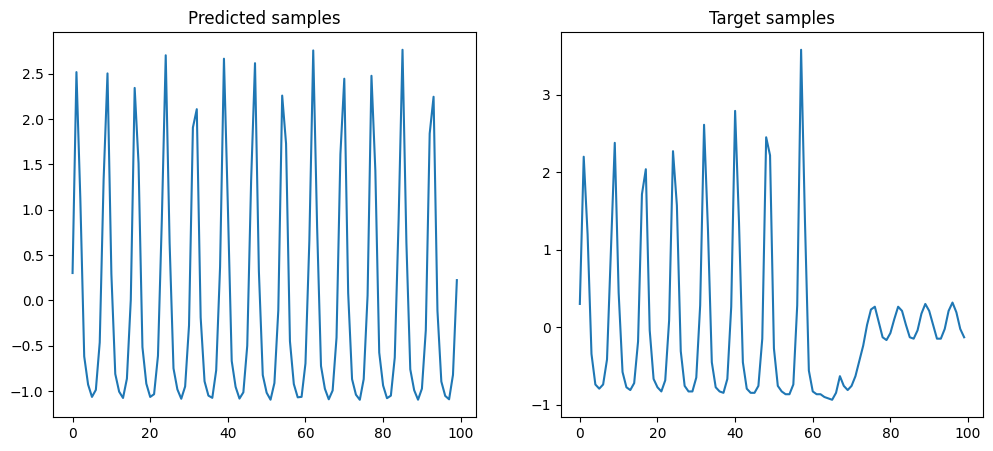

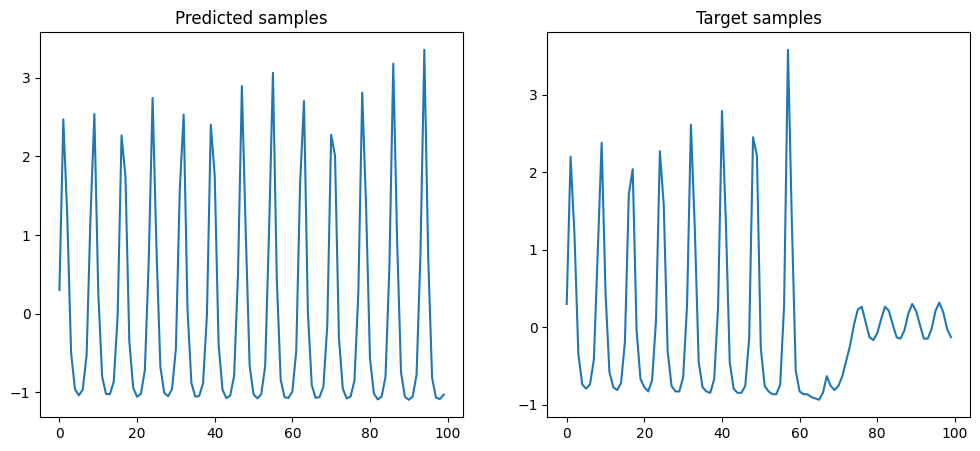

In [19]:
visualize_prediction_performance(pred_samples_hidden_8, norm_val_set)
visualize_prediction_performance(pred_samples_hidden_32, norm_val_set)

# 4 Report

Write a report of maximum 4 pages (including text and figures) to discuss the exercises in sections 1, 2 and 3.